In [1]:
import lettuce as lt
from matplotlib import pyplot as plt
import numpy as np
import time
import torch

In [2]:
#definiere "run" Funktion, die eine Simulation mit dreieckigem Hinderniss
#    durchführt.
#Simulationslänge ist von der y-Auflösung ny abhängig (ny*100 steps)
#
def run(step=100, ny=100, re=50, *axes):
    # ny: y-Auflösung, axes: Koordinatensystem(e), * erstellt ein Tupel aller übergebenen axes
    # ny=100 ist nur der default...
    
    lattice = lt.Lattice(lt.D2Q9, "cuda:0")
    flow = lt.Cylinder2D(
        (2*ny, ny), #shape der 2D-Box ist XxY: 2ny x ny
        reynolds_number=re, #50.0
        mach_number=0.05,
        lattice=lattice,
        domain_length_x=10.1, # in PU
    )
    x, y = flow.grid #gibt ein Meshgrid zurück: x-2D-Array, y-2D-Array
    
    condition = np.sqrt((x-2.5)**2+(y-2.5)**2) < 0.5 #die Kreisgleichung rechnet in PU, d.h. die Auflösung spielt hier keine Rolle(!)
    flow.mask[np.where(condition)] = 1 #erstelle Obstacle Form (mask als Bool)
    #print("mask dim.:",flow.mask.shape)
    axes[0].imshow(flow.mask.T, origin="lower") #erstellt ein 2D-Bild der Maske
        #flow.mask.T ist die Transponierte von flow.mask (!)
        #der (0,0)-Punkt der Grafik sitzt unten links ("lower")
    
    tau = flow.units.relaxation_parameter_lu
    sim = lt.Simulation(flow, lattice, lt.KBCCollision2D(lattice, tau), 
                        lt.StandardStreaming(lattice))
    
    # Vorticity Objekt erstellen
    vorticity=lt.Vorticity(lattice,flow)
    # sim.reporters.append(lt.ObservableReporter(vorticity, interval=5,out=None))  # reporter können nur skalare Werte reporten...
    #vorticity(sim.f) # Berechnet die Vortizität zur aktuellen Verteilungsfunktion
    
    # VTK Reporter
    VTKreport = lt.VTKReporter(lattice, flow, interval=50, filename_base="/mnt/ScratchHDD1/Max_Scratch/cylinder_vtk/out")
    sim.reporters.append(VTKreport)
    
    t_start=time.time()
    n_steps=step
    sim.step(n_steps) #Simulation mit Schrittzahl = 100*y-Auflösung
    print("PU-Time: ",flow.units.convert_time_to_pu(n_steps)," seconds")
    print("Re=",re)
    print("number of steps:",n_steps)
    print("runtime: ",time.time()-t_start, "seconds")
    
    u = flow.units.convert_velocity_to_pu(lattice.u(sim.f).detach().cpu().numpy())
        #Geschwindigkeit wird als numpy-Array in den RAM geschrieben
    
    return axes[1].imshow(vorticity(sim.f).cpu().T, origin="lower")
    # return axes[1].imshow(u[0,...].T, origin="lower")
        #erstellt ein 2D-Bild des Geschwindigkeitsfeldes
        # Daten müssen von GPU auf CPU transferierit werden vor dem plotten

    print("Max Velocity: ", float(u.max()))
        #wird nicht ausgeführt, weil das schon hinter dem return ist...bruh

In [3]:
def run_and_plot(ny,nstep,re):
    fig, axes = plt.subplots(1,2, figsize=(10,3)) #erstelle Figure
    fig.subplots_adjust(right=0.85) #Kürze figure-Größe rechts auf 85%
    im2 = run(nstep, ny, re, *axes) #führe run() aus, übergebe die leeren Koordinatensysteme und die y-Auflösung
    cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7]) #fügt Koordinatensystem für colorbar hinzu
    fig.colorbar(im2, cax=cbar_ax) #fügt colorbar hinzu, zugehörig zum zweiten Koordinatensystem
    print("left: mask, right: mag.vorticity") #oder mag.velocity -> ändere in run (!)

In [4]:
#run_and_plot(ny=100,nstep=100,re=100)

In [5]:
#run_and_plot(ny=100,nstep=1000, re=100)

PU-Time:  145.78094297038052  seconds
Re= 1000
number of steps: 100000
runtime:  174.480717420578 seconds
left: mask, right: mag.vorticity


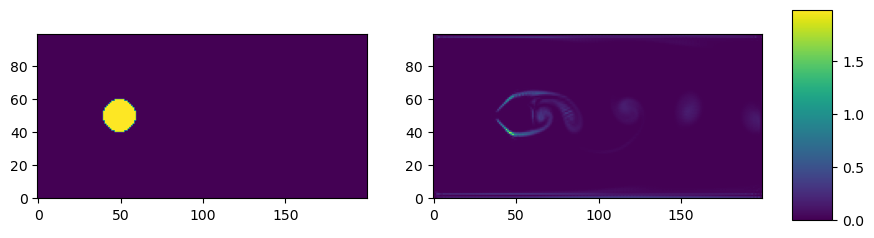

In [7]:
run_and_plot(ny=100,nstep=100000, re=1000)